## Evaluate Separation

In [3]:
import nussl
import matplotlib.pyplot as plt
import time
import warnings
import torch

warnings.filterwarnings("ignore")

### Listen to room (the state) at beginning of episode

In [4]:
room_sound_path = '../data/new_states/new3-1.wav'
room_sound = nussl.AudioSignal(room_sound_path)
room_sound.embed_audio(display=False)

Then select the right model (usually the latest episode).

In [23]:
# look in experimentx.py to get correct path
model_path = '../models/test-exp-3-50eps/sp_ep49.pt'

Then put the mix through the model to hear the result.

Matching file found at /home/ubuntu/.nussl/audio/wsj_speech_mixture_ViCfBJj.mp3, skipping download.


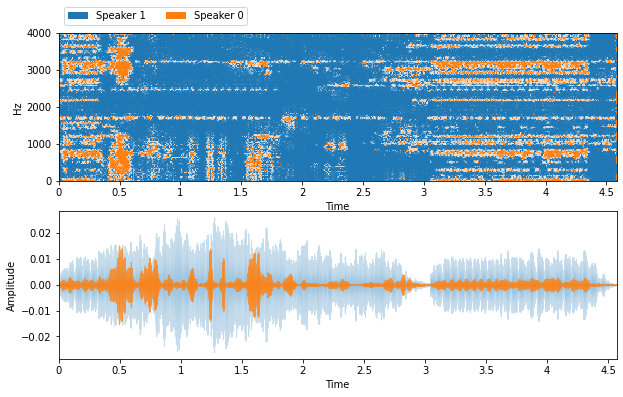


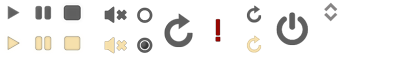
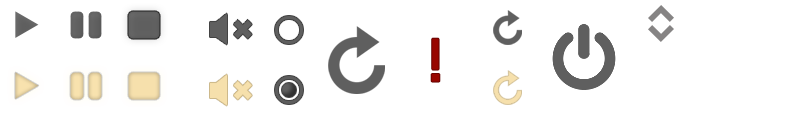
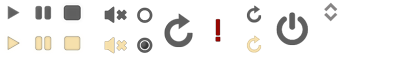

In [24]:
start_time = time.time()

def visualize_and_embed(sources):
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    nussl.utils.visualize_sources_as_masks(sources,
        y_axis='linear', db_cutoff=-80, alpha_amount=2.0)
    plt.subplot(212)
    nussl.utils.visualize_sources_as_waveform(
        sources, show_legend=False)
    plt.show()
    nussl.play_utils.multitrack(sources)

audio_path = nussl.efz_utils.download_audio_file(
    'wsj_speech_mixture_ViCfBJj.mp3')

# for testing on new data
audio_files = [
    '../sounds/dry_recordings/dev/050/050a0501.wav',
    '../sounds/dry_recordings/dev/051/051a0502.wav'
]
signals = []
gains = [1, 1]

for i, a in enumerate(audio_files):
    sig = nussl.AudioSignal(a)
    signals.append(sig * gains[i])
    
min_length = min([x.signal_duration for x in signals])
[x.truncate_seconds(min_length) for x in signals]
audio_signal = sum(signals)

separator = nussl.separation.deep.DeepAudioEstimation(
    room_sound, model_path=None)

model_dict = torch.load(model_path)
model = nussl.ml.SeparationModel(model_dict['config'])
model.load_state_dict(model_dict['state_dict'])

separator.model = model
separator.metadata = {
    'sample_rate': model_dict['sample_rate'],
    'stft_params': audio_signal.stft_params,
    'num_channels': 1
}
separator.transform = nussl.datasets.transforms.Compose([
    nussl.datasets.transforms.GetAudio(),
    nussl.datasets.transforms.ToSeparationModel(),
])
separator.device = 'cpu'

estimates = separator()
ibm = nussl.separation.benchmark.IdealBinaryMask(
    room_sound, estimates, 
)
estimates = ibm()

estimates = {
    f'Speaker {i}': e for i, e in enumerate(estimates)
}

visualize_and_embed(estimates)

In [25]:
estimates['Speaker 0'].embed_audio()

In [26]:
estimates['Speaker 1'].embed_audio()

In [435]:
separator.model_output['mask'].mean(dim=[0, 1, 2, 3])

tensor([0.6770, 0.3230])

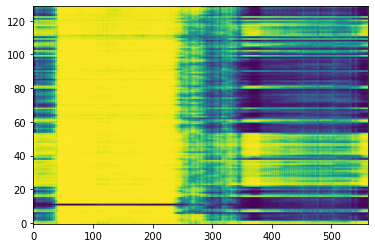

In [412]:
# spectrogram is multiplied by the mask to separate sources 
plt.imshow(separator.model_output['mask'][0, ..., 0, 1].cpu().data.numpy().T, 
           origin='lower', aspect='auto', vmin=0.0, vmax=1.0)

In [413]:
separator.model_output['mask'][0, 0, 0]

tensor([[0.0552, 0.9448]])

## Separating with spatial clustering

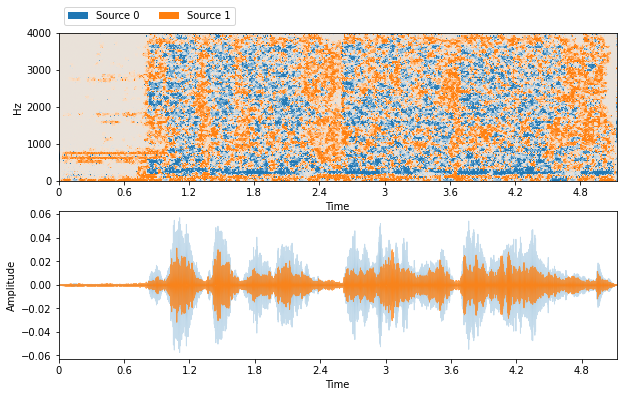


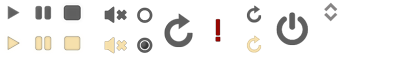
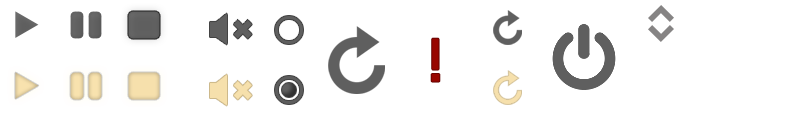
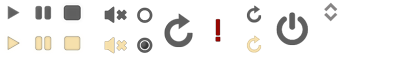

In [403]:
spcl = nussl.separation.spatial.SpatialClustering(
    room_sound, num_sources=2, mask_type='binary'
)
estimates = spcl()

estimates = {
    f'Source {i}': e for i, e in enumerate(estimates)
}

visualize_and_embed(estimates)